In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Data Loading

In [16]:
import yfinance as yf

df_full = yf.download('JPM', period='1y').reset_index()
df_full.to_csv('JPM.csv',index=False)
print(len(df_full))
df_full.head()

[*********************100%***********************]  1 of 1 completed

252


,Date,Open,High,Low,Close,Adj Close,Volume
0,2023-10-04,143.190002,143.470001,141.929993,143.350006,139.832916,8128700
1,2023-10-05,142.039993,143.100006,140.830002,142.899994,140.422501,8576200
2,2023-10-06,142.910004,145.880005,142.139999,145.100006,142.584366,10269400
3,2023-10-09,143.660004,145.399994,143.500000,144.770004,142.260071,6964900
4,2023-10-10,145.419998,146.770004,145.279999,145.649994,143.124802,11288800


In [17]:
df_full = pd.read_csv('JPM.csv')

#  Agents

* Turtle Trading agent
* Moving Average agent
* Signal Rolling agent
* Policy Gradient agent
* Q-learning agent
* Evolution Strategy agent

## Turtle Trading Agent

In [30]:
df= df_full.copy()
name = 'Turtle Trading Agent'
count = int(np.ceil(len(df) * 0.1))
signals = pd.DataFrame(index=df.index)
signals['signal'] = 0.0
signals['trend'] = df['Close']
signals['RollingMax'] = (signals.trend.shift(1).rolling(count).max())
signals['RollingMin'] = (signals.trend.shift(1).rolling(count).min())
signals.loc[signals['RollingMax'] < signals.trend, 'signal'] = -1
signals.loc[signals['RollingMin'] > signals.trend, 'signal'] = 1
signals

,signal,trend,RollingMax,RollingMin
0,0.0,143.350006,NaN,NaN
1,0.0,142.899994,NaN,NaN
2,0.0,145.100006,NaN,NaN
3,0.0,144.770004,NaN,NaN
4,0.0,145.649994,NaN,NaN
...,...,...,...,...
247,0.0,210.500000,224.800003,204.320007
248,0.0,210.860001,224.800003,204.320007
249,0.0,207.039993,224.800003,204.320007
250,0.0,207.289993,224.800003,204.320007


In [31]:
def buy_stock(
    real_movement,
    signal,
    initial_money = 10000,
    max_buy = 1,
    max_sell = 1,
):
    """
    real_movement = actual movement in the real world
    delay = how much interval you want to delay to change our decision from buy to sell, vice versa
    initial_state = 1 is buy, 0 is sell
    initial_money = 1000, ignore what kind of currency
    max_buy = max quantity for share to buy
    max_sell = max quantity for share to sell
    """
    starting_money = initial_money
    states_sell = []
    states_buy = []
    current_inventory = 0

    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares < 1:
            print(
                'day %d: total balances %f, not enough money to buy a unit price %f'
                % (i, initial_money, real_movement[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print(
                'day %d: buy %d units at price %f, total balance %f'
                % (i, buy_units, buy_units * real_movement[i], initial_money)
            )
            states_buy.append(0)
        return initial_money, current_inventory

    for i in range(real_movement.shape[0] - int(0.025 * len(df))):
        state = signal[i]
        if state == 1:
            initial_money, current_inventory = buy(
                i, initial_money, current_inventory
            )
            states_buy.append(i)
        elif state == -1:
            if current_inventory == 0:
                    print('day %d: cannot sell anything, inventory 0' % (i))
            else:
                if current_inventory > max_sell:
                    sell_units = max_sell
                else:
                    sell_units = current_inventory
                current_inventory -= sell_units
                total_sell = sell_units * real_movement[i]
                initial_money += total_sell
                try:
                    invest = (
                        (real_movement[i] - real_movement[states_buy[-1]])
                        / real_movement[states_buy[-1]]
                    ) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (i, sell_units, total_sell, invest, initial_money)
                )
            states_sell.append(i)

    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest

In [32]:
states_buy, states_sell, total_gains, invest = buy_stock(df.Close, signals['signal'])

day 29: cannot sell anything, inventory 0
day 30: cannot sell anything, inventory 0
day 31: cannot sell anything, inventory 0
day 32: cannot sell anything, inventory 0
day 33: cannot sell anything, inventory 0
day 35: cannot sell anything, inventory 0
day 36: cannot sell anything, inventory 0
day 39: cannot sell anything, inventory 0
day 40: cannot sell anything, inventory 0
day 41: cannot sell anything, inventory 0
day 42: cannot sell anything, inventory 0
day 46: cannot sell anything, inventory 0
day 47: cannot sell anything, inventory 0
day 48: cannot sell anything, inventory 0
day 49: cannot sell anything, inventory 0
day 50: cannot sell anything, inventory 0
day 51: cannot sell anything, inventory 0
day 52: cannot sell anything, inventory 0
day 53: cannot sell anything, inventory 0
day 58: cannot sell anything, inventory 0
day 59: cannot sell anything, inventory 0
day 61: cannot sell anything, inventory 0
day 64: cannot sell anything, inventory 0
day 77: cannot sell anything, inve

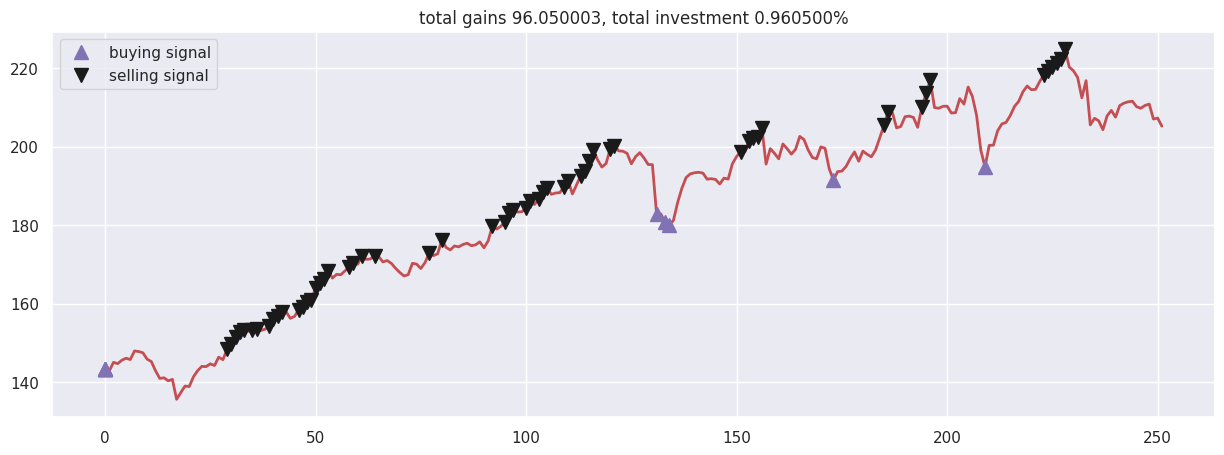

In [33]:
close = df['Close']
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
# plt.savefig('output/'+name+'.png')
plt.show()


## Moving Average agent

In [34]:
df= df_full.copy()
name = 'Moving Average agent'

short_window = int(0.025 * len(df))
long_window = int(0.05 * len(df))

signals = pd.DataFrame(index=df.index)
signals['signal'] = 0.0

signals['short_ma'] = df['Close'].rolling(window=short_window, min_periods=1, center=False).mean()
signals['long_ma'] = df['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

signals['signal'][short_window:] = np.where(signals['short_ma'][short_window:]
                                            > signals['long_ma'][short_window:], 1.0, 0.0)
signals['positions'] = signals['signal'].diff()

signals

<ipython-input-34-2980e43f3e79>:13: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  signals['signal'][short_window:] = np.where(signals['short_ma'][short_window:]


,signal,short_ma,long_ma,positions
0,0.0,143.350006,143.350006,NaN
1,0.0,143.125000,143.125000,0.0
2,0.0,143.783335,143.783335,0.0
3,0.0,144.030003,144.030003,0.0
4,0.0,144.354001,144.354001,0.0
...,...,...,...,...
247,1.0,210.764999,209.219167,0.0
248,1.0,210.726667,209.574167,0.0
249,1.0,209.993332,209.800832,0.0
250,0.0,209.276665,209.753332,-1.0


In [35]:
def buy_stock(
    real_movement,
    signal,
    initial_money = 10000,
    max_buy = 1,
    max_sell = 1,
):
    """
    real_movement = actual movement in the real world
    delay = how much interval you want to delay to change our decision from buy to sell, vice versa
    initial_state = 1 is buy, 0 is sell
    initial_money = 1000, ignore what kind of currency
    max_buy = max quantity for share to buy
    max_sell = max quantity for share to sell
    """
    starting_money = initial_money
    states_sell = []
    states_buy = []
    current_inventory = 0

    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares < 1:
            print(
                'day %d: total balances %f, not enough money to buy a unit price %f'
                % (i, initial_money, real_movement[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print(
                'day %d: buy %d units at price %f, total balance %f'
                % (i, buy_units, buy_units * real_movement[i], initial_money)
            )
            states_buy.append(0)
        return initial_money, current_inventory

    for i in range(real_movement.shape[0] - int(0.025 * len(df))):
        state = signal[i]
        if state == 1:
            initial_money, current_inventory = buy(
                i, initial_money, current_inventory
            )
            states_buy.append(i)
        elif state == -1:
            if current_inventory == 0:
                    print('day %d: cannot sell anything, inventory 0' % (i))
            else:
                if current_inventory > max_sell:
                    sell_units = max_sell
                else:
                    sell_units = current_inventory
                current_inventory -= sell_units
                total_sell = sell_units * real_movement[i]
                initial_money += total_sell
                try:
                    invest = (
                        (real_movement[i] - real_movement[states_buy[-1]])
                        / real_movement[states_buy[-1]]
                    ) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (i, sell_units, total_sell, invest, initial_money)
                )
            states_sell.append(i)
    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest

In [36]:
states_buy, states_sell, total_gains, invest = buy_stock(df.Close, signals['positions'])

day 6: buy 1 units at price 145.809998, total balance 9854.190002
day 13, sell 1 units at price 141.000000, investment -3.298812 %, total balance 9995.190002,
day 23: buy 1 units at price 144.080002, total balance 9851.110001
day 70, sell 1 units at price 167.990005, investment 16.594950 %, total balance 10019.100006,
day 77: buy 1 units at price 172.940002, total balance 9846.160004
day 128, sell 1 units at price 197.149994, investment 13.999070 %, total balance 10043.309998,
day 140: buy 1 units at price 193.369995, total balance 9849.940002
day 148, sell 1 units at price 191.750000, investment -0.837770 %, total balance 10041.690002,
day 150: buy 1 units at price 197.500000, total balance 9844.190002
day 161, sell 1 units at price 200.710007, investment 1.625320 %, total balance 10044.900009,
day 166: buy 1 units at price 201.820007, total balance 9843.080002
day 171, sell 1 units at price 199.610001, investment -1.095038 %, total balance 10042.690002,
day 180: buy 1 units at price 

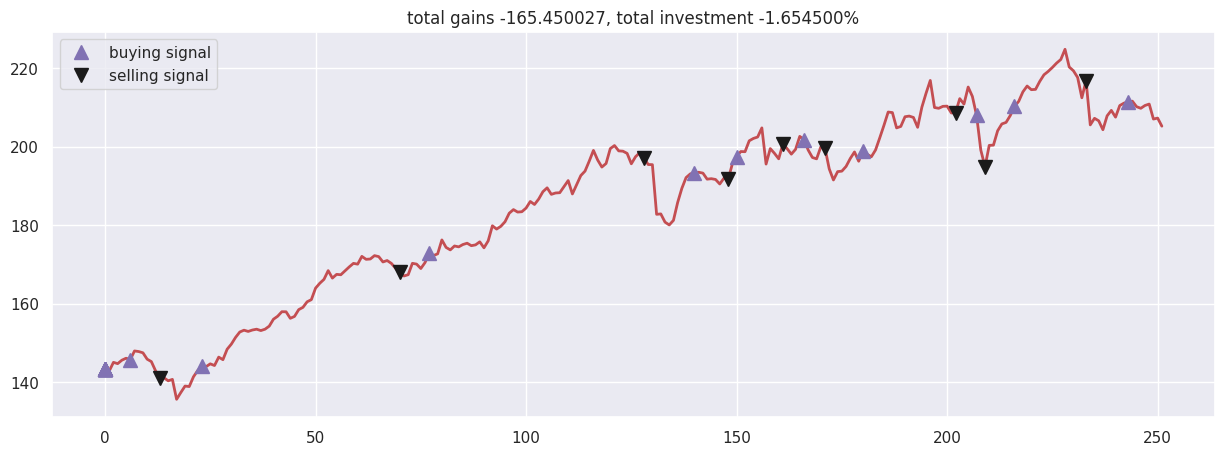

In [37]:
close = df['Close']
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
# plt.savefig('output/'+name+'.png')
plt.show()

## Signal Rolling agent

In [38]:
df= df_full.copy()
name = 'Signal Rolling agent'

In [39]:
def buy_stock(
    real_movement,
    delay = 5,
    initial_state = 1,
    initial_money = 10000,
    max_buy = 1,
    max_sell = 1,
):
    """
    real_movement = actual movement in the real world
    delay = how much interval you want to delay to change our decision from buy to sell, vice versa
    initial_state = 1 is buy, 0 is sell
    initial_money = 1000, ignore what kind of currency
    max_buy = max quantity for share to buy
    max_sell = max quantity for share to sell
    """
    starting_money = initial_money
    delay_change_decision = delay
    current_decision = 0
    state = initial_state
    current_val = real_movement[0]
    states_sell = []
    states_buy = []
    current_inventory = 0

    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares < 1:
            print(
                'day %d: total balances %f, not enough money to buy a unit price %f'
                % (i, initial_money, real_movement[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print(
                'day %d: buy %d units at price %f, total balance %f'
                % (i, buy_units, buy_units * real_movement[i], initial_money)
            )
            states_buy.append(0)
        return initial_money, current_inventory

    if state == 1:
        initial_money, current_inventory = buy(
            0, initial_money, current_inventory
        )

    for i in range(1, real_movement.shape[0], 1):
        if real_movement[i] < current_val and state == 0:
            if current_decision < delay_change_decision:
                current_decision += 1
            else:
                state = 1
                initial_money, current_inventory = buy(
                    i, initial_money, current_inventory
                )
                current_decision = 0
                states_buy.append(i)
        if real_movement[i] > current_val and state == 1:
            if current_decision < delay_change_decision:
                current_decision += 1
            else:
                state = 0

                if current_inventory == 0:
                    print('day %d: cannot sell anything, inventory 0' % (i))
                else:
                    if current_inventory > max_sell:
                        sell_units = max_sell
                    else:
                        sell_units = current_inventory
                    current_inventory -= sell_units
                    total_sell = sell_units * real_movement[i]
                    initial_money += total_sell
                    try:
                        invest = (
                            (real_movement[i] - real_movement[states_buy[-1]])
                            / real_movement[states_buy[-1]]
                        ) * 100
                    except:
                        invest = 0
                    print(
                        'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                        % (i, sell_units, total_sell, invest, initial_money)
                    )

                current_decision = 0
                states_sell.append(i)
        current_val = real_movement[i]
    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest

In [40]:
states_buy, states_sell, total_gains, invest = buy_stock(df.Close, initial_state = 1,
                                                         delay = 4, initial_money = 10000)

day 0: buy 1 units at price 143.350006, total balance 9856.649994
day 14, sell 1 units at price 141.169998, investment -1.520759 %, total balance 9997.819992,
day 26: buy 1 units at price 144.289993, total balance 9853.529999
day 32, sell 1 units at price 152.820007, investment 5.911716 %, total balance 10006.350006,
day 54: buy 1 units at price 166.550003, total balance 9839.800003
day 61, sell 1 units at price 172.080002, investment 3.320323 %, total balance 10011.880005,
day 69: buy 1 units at price 169.050003, total balance 9842.830002
day 79, sell 1 units at price 172.729996, investment 2.176866 %, total balance 10015.559998,
day 90: buy 1 units at price 174.259995, total balance 9841.300003
day 96, sell 1 units at price 183.070007, investment 5.055671 %, total balance 10024.370010,
day 117: buy 1 units at price 196.619995, total balance 9827.750015
day 127, sell 1 units at price 198.479996, investment 0.945988 %, total balance 10026.230011,
day 133: buy 1 units at price 180.80000

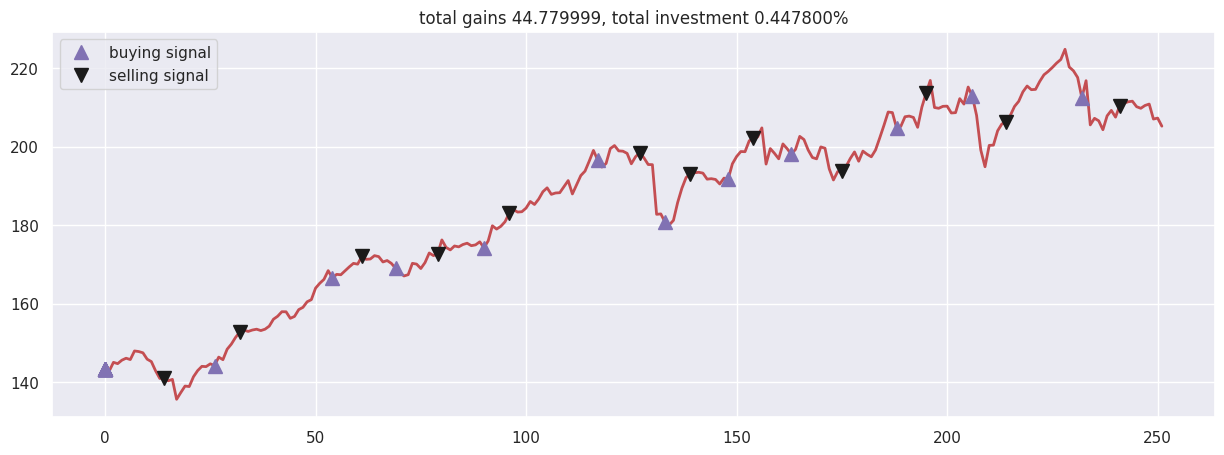

In [41]:
close = df['Close']
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
# plt.savefig('output/'+name+'.png')
plt.show()

## Policy Gradient agent

In [52]:
import tensorflow as tf
from tqdm import tqdm, trange

In [58]:
import numpy as np
import tensorflow as tf
from collections import deque
import random

df = df_full.copy()
name = 'Policy gradient agent'

class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen=1000)
        self.inventory = []

        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999

        # Define the Q-learning model
        self.model = self.build_model()

    def build_model(self):
        # Build a simple fully connected neural network using Keras
        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(self.state_size,)),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(self.action_size, activation='linear')
        ])
        model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-5),
                      loss='mean_squared_error')
        return model

    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        q_values = self.model.predict(state, verbose=0)
        return np.argmax(q_values[0])

    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def replay(self, batch_size):
        mini_batch = random.sample(self.memory, batch_size)
        replay_size = len(mini_batch)
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])

        Q = self.model.predict(states, verbose=0)
        Q_new = self.model.predict(new_states, verbose=0)

        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])

        # Fit the model
        self.model.fit(states, Q, epochs=1, verbose=0, batch_size=batch_size)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)

            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                # print(f'day {t}: buy 1 unit at price {self.trend[t]:.2f}, total balance {initial_money:.2f}')

            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((self.trend[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                # print(f'day {t}, sell 1 unit at price {self.trend[t]:.2f}, investment {invest:.2f} %, total balance {initial_money:.2f}')

            state = next_state

        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest

    def train(self, iterations, checkpoint, initial_money):
        for i in tqdm(range(iterations), desc="Training"):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money

            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)

                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]

                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]

                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, next_state, starting_money < initial_money))
                state = next_state

                batch_size = min(self.batch_size, len(self.memory))
                self.replay(batch_size)

            if (i + 1) % checkpoint == 0:
                print(f'epoch: {i + 1}, total rewards: {total_profit:.2f}, total money: {starting_money:.2f}')



In [59]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
agent = Agent(state_size = window_size,
             window_size = window_size,
             trend = close,
             skip = skip,
             batch_size=len(close))
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

Training:  10%|█         | 10/100 [12:05<1:40:38, 67.10s/it]

epoch: 10, total rewards: 9.00, total money: 10009.00


Training:  20%|██        | 20/100 [23:10<1:28:22, 66.28s/it]

epoch: 20, total rewards: 12.17, total money: 10012.17


Training:  30%|███       | 30/100 [34:10<1:16:07, 65.25s/it]

epoch: 30, total rewards: -5.72, total money: 9994.28


Training:  40%|████      | 40/100 [44:55<1:04:33, 64.55s/it]

epoch: 40, total rewards: -0.75, total money: 9999.25


Training:  50%|█████     | 50/100 [56:10<56:13, 67.46s/it]

epoch: 50, total rewards: -0.86, total money: 9999.14


Training:  60%|██████    | 60/100 [1:07:04<43:21, 65.03s/it]

epoch: 60, total rewards: 39.75, total money: 10039.75


Training:  70%|███████   | 70/100 [1:18:12<33:29, 66.98s/it]

epoch: 70, total rewards: 25.34, total money: 10025.34


Training:  80%|████████  | 80/100 [1:29:02<21:38, 64.90s/it]

epoch: 80, total rewards: 10.04, total money: 10010.04


Training:  90%|█████████ | 90/100 [1:40:00<10:50, 65.05s/it]

epoch: 90, total rewards: 23.57, total money: 10023.57


Training: 100%|██████████| 100/100 [1:50:47<00:00, 66.48s/it]

epoch: 100, total rewards: 31.82, total money: 10031.82


In [60]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

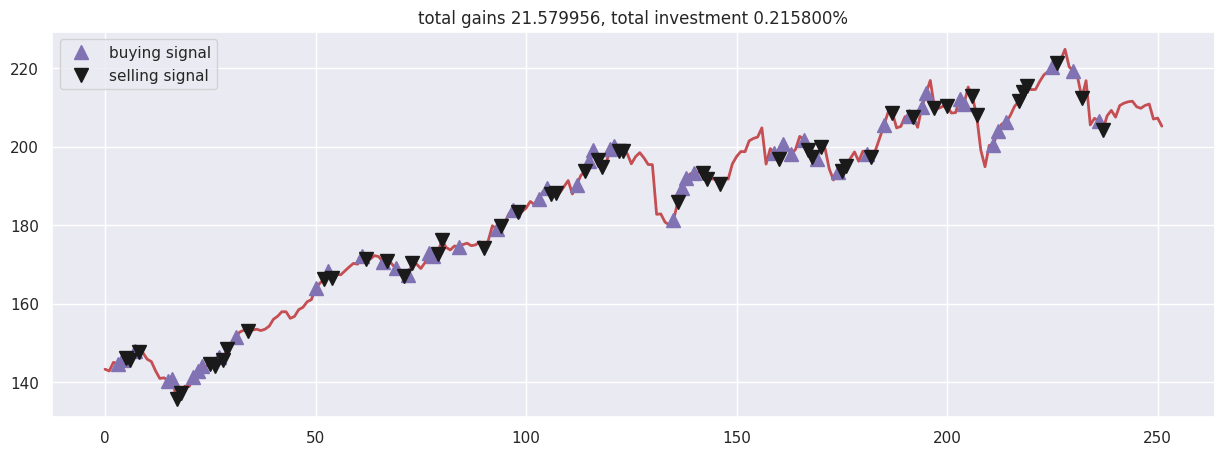

In [61]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
# plt.savefig('output/'+name+'.png')
plt.show()

## Q-learning agent

In [ ]:
from collections import deque
import random

df= df_full.copy()
name = 'Q-learning agent'

class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []

        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999

        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()
        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])
        feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed, self.action_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.GradientDescentOptimizer(1e-5).minimize(
            self.cost
        )
        self.sess.run(tf.global_variables_initializer())

    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(
            self.sess.run(self.logits, feed_dict = {self.X: state})[0]
        )

    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost

    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)

            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))


            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )

            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest

    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)

                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]

                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]

                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest,
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [ ]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size,
              window_size = window_size,
              trend = close,
              skip = skip,
              batch_size = batch_size)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: 274.710201.3, cost: 0.810730, total money: 10274.710201
epoch: 20, total rewards: 161.429929.3, cost: 0.406487, total money: 10161.429929
epoch: 30, total rewards: 89.659849.3, cost: 0.225568, total money: 10089.659849
epoch: 40, total rewards: 121.209836.3, cost: 0.152499, total money: 10121.209836
epoch: 50, total rewards: 94.869810.3, cost: 0.120762, total money: 10094.869810
epoch: 60, total rewards: 123.609922.3, cost: 0.097353, total money: 10123.609922
epoch: 70, total rewards: 130.149901.3, cost: 0.131718, total money: 10130.149901
epoch: 80, total rewards: 55.369871.3, cost: 0.072531, total money: 10055.369871
epoch: 90, total rewards: 177.780026.3, cost: 0.062346, total money: 10177.780026
epoch: 100, total rewards: 151.249997.3, cost: 0.056566, total money: 10151.249997
epoch: 110, total rewards: 101.629942.3, cost: 0.050717, total money: 10101.629942
epoch: 120, total rewards: 138.329892.3, cost: 0.075178, total money: 10138.329892
epoch: 130, tota

In [ ]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 4: buy 1 unit at price 790.510010, total balance 9209.489990
day 5, sell 1 unit at price 785.309998, investment -0.657805 %, total balance 9994.799988,
day 14: buy 1 unit at price 768.270020, total balance 9226.529968
day 16, sell 1 unit at price 761.679993, investment -0.857775 %, total balance 9988.209961,
day 22: buy 1 unit at price 762.520020, total balance 9225.689941
day 23, sell 1 unit at price 759.109985, investment -0.447206 %, total balance 9984.799926,
day 28: buy 1 unit at price 796.099976, total balance 9188.699950
day 29, sell 1 unit at price 797.070007, investment 0.121848 %, total balance 9985.769957,
day 32: buy 1 unit at price 794.200012, total balance 9191.569945
day 35: buy 1 unit at price 791.260010, total balance 8400.309935
day 36: buy 1 unit at price 789.909973, total balance 7610.399962
day 37, sell 1 unit at price 791.549988, investment -0.333672 %, total balance 8401.949950,
day 38, sell 1 unit at price 785.049988, investment -0.784827 %, total balance 91

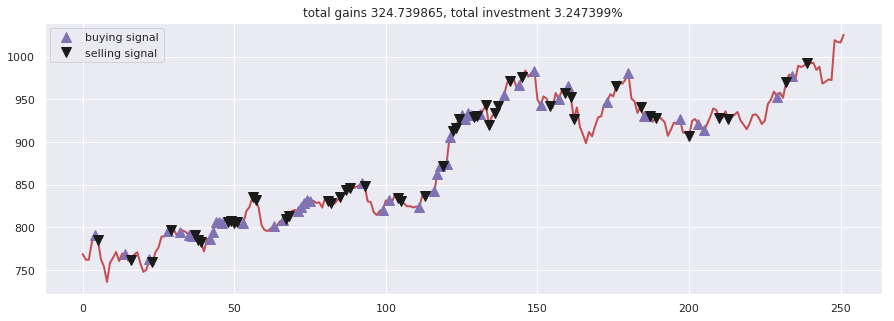

In [ ]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
# plt.savefig('output/'+name+'.png')
plt.show()

## Evolution Strategy agent

In [62]:
import time
import pkg_resources
import types

df= df_full.copy()
name = 'Evolution Strategy agent'


def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            name = val.__name__.split('.')[0]
        elif isinstance(val, type):
            name = val.__module__.split('.')[0]
        poorly_named_packages = {'PIL': 'Pillow', 'sklearn': 'scikit-learn'}
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]
        yield name


imports = list(set(get_imports()))
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name != 'pip':
        requirements.append((m.project_name, m.version))

for r in requirements:
    print('{}=={}'.format(*r))

matplotlib==3.7.1
numpy==1.26.4
pandas==2.2.2
seaborn==0.13.1
tensorflow==2.17.0
tqdm==4.66.5
yfinance==0.2.44


In [63]:
class Deep_Evolution_Strategy:

    inputs = None

    def __init__(
        self, weights, reward_function, population_size, sigma, learning_rate
    ):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        return self.weights

    def train(self, epoch = 100, print_every = 1):
        lasttime = time.time()
        for i in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            for k in range(self.population_size):
                weights_population = self._get_weight_from_population(
                    self.weights, population[k]
                )
                rewards[k] = self.reward_function(weights_population)
            rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-7)
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = (
                    w
                    + self.learning_rate
                    / (self.population_size * self.sigma)
                    * np.dot(A.T, rewards).T
                )
            if (i + 1) % print_every == 0:
                print(
                    'iter %d. reward: %f'
                    % (i + 1, self.reward_function(self.weights))
                )
        print('time taken to train:', time.time() - lasttime, 'seconds')


class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.randn(input_size, layer_size),
            np.random.randn(layer_size, output_size),
            np.random.randn(1, layer_size),
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        decision = np.dot(feed, self.weights[1])
        return decision

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

In [64]:
class Agent:

    POPULATION_SIZE = 15
    SIGMA = 0.1
    LEARNING_RATE = 0.03

    def __init__(self, model, window_size, trend, skip, initial_money):
        self.model = model
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.initial_money = initial_money
        self.es = Deep_Evolution_Strategy(
            self.model.get_weights(),
            self.get_reward,
            self.POPULATION_SIZE,
            self.SIGMA,
            self.LEARNING_RATE,
        )

    def act(self, sequence):
        decision = self.model.predict(np.array(sequence))
        return np.argmax(decision[0])

    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def get_reward(self, weights):
        initial_money = self.initial_money
        starting_money = initial_money
        self.model.weights = weights
        state = self.get_state(0)
        inventory = []
        quantity = 0
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)

            if action == 1 and starting_money >= self.trend[t]:
                inventory.append(self.trend[t])
                starting_money -= close[t]

            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                starting_money += self.trend[t]

            state = next_state
        return ((starting_money - initial_money) / initial_money) * 100

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, print_every = checkpoint)

    def buy(self):
        initial_money = self.initial_money
        state = self.get_state(0)
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)

            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))

            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            state = next_state

        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest

In [67]:
close = df.Close.values.tolist()
window_size = 30
skip = 1
initial_money = 10000

model = Model(input_size = window_size, layer_size = 500, output_size = 3)
agent = Agent(model = model,
              window_size = window_size,
              trend = close,
              skip = skip,
              initial_money = initial_money)
agent.fit(iterations = 500, checkpoint = 10)

iter 10. reward: 1.236300
iter 20. reward: 4.690200
iter 30. reward: 5.060300
iter 40. reward: 0.249900
iter 50. reward: 7.910200
iter 60. reward: 7.040099
iter 70. reward: 6.164099
iter 80. reward: 8.684400
iter 90. reward: 11.997800
iter 100. reward: 10.821500
iter 110. reward: 13.640000
iter 120. reward: 10.118600
iter 130. reward: 9.807500
iter 140. reward: 10.554000
iter 150. reward: 9.461600
iter 160. reward: 8.974100
iter 170. reward: 13.728000
iter 180. reward: 13.676001
iter 190. reward: 13.192001
iter 200. reward: 12.957301
iter 210. reward: 14.562201
iter 220. reward: 15.475601
iter 230. reward: 15.407601
iter 240. reward: 13.604901
iter 250. reward: 14.768100
iter 260. reward: 12.344900
iter 270. reward: 15.254901
iter 280. reward: 15.200001
iter 290. reward: 16.122700
iter 300. reward: 11.214600
iter 310. reward: 16.332000
iter 320. reward: 15.479800
iter 330. reward: 15.353500
iter 340. reward: 15.901800
iter 350. reward: 17.776800
iter 360. reward: 17.379500
iter 370. re

In [68]:
states_buy, states_sell, total_gains, invest = agent.buy()

day 0: buy 1 unit at price 143.350006, total balance 9856.649994
day 1: buy 1 unit at price 142.899994, total balance 9713.750000
day 3: buy 1 unit at price 144.770004, total balance 9568.979996
day 4: buy 1 unit at price 145.649994, total balance 9423.330002
day 6: buy 1 unit at price 145.809998, total balance 9277.520004
day 8: buy 1 unit at price 147.850006, total balance 9129.669998
day 9: buy 1 unit at price 147.529999, total balance 8982.139999
day 11: buy 1 unit at price 145.289993, total balance 8836.850006
day 12, sell 1 unit at price 142.949997, investment -0.279044 %, total balance 8979.800003,
day 13: buy 1 unit at price 141.000000, total balance 8838.800003
day 14: buy 1 unit at price 141.169998, total balance 8697.630005
day 15: buy 1 unit at price 140.399994, total balance 8557.230011
day 16: buy 1 unit at price 140.759995, total balance 8416.470016
day 17: buy 1 unit at price 135.690002, total balance 8280.780014
day 20: buy 1 unit at price 138.940002, total balance 814

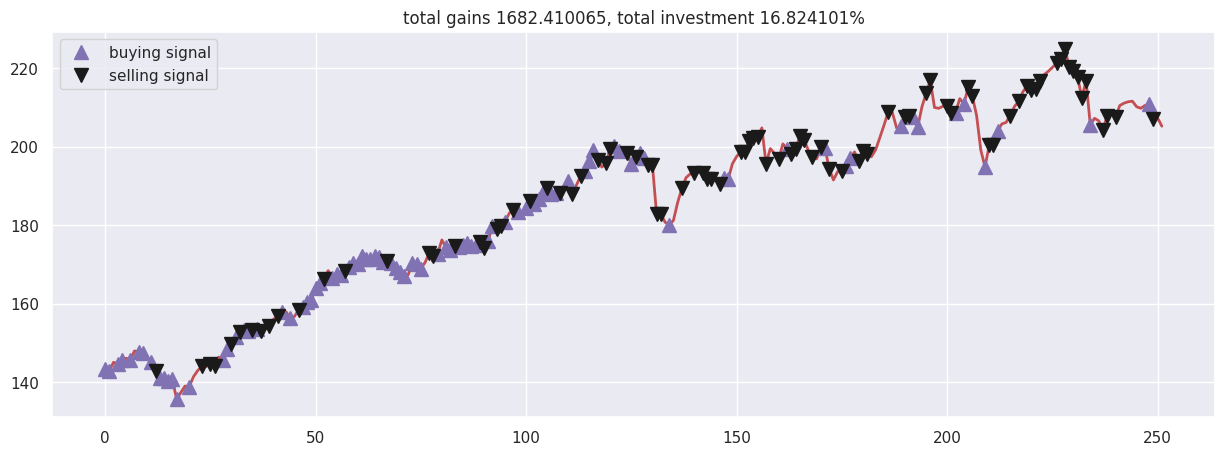

In [69]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
# plt.savefig('output/'+name+'.png')
plt.show()